In [213]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime

In [214]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

In [215]:
filepath = "nsw_road_crash_data_2018-2022_crash.csv"
if os.path.isfile(filepath):
    print("loading from file")
else:
    share_link = "https://drive.google.com/file/d/1O0uZgDLg6vooluUgi_7m6Us_VdxkV5Pt/view?usp=sharing"
    file_id = share_link.split('/d/')[1].split('/')[0]
    filepath = f"https://drive.google.com/uc?export=download&id={file_id}"
    print("reading from google drive")

crash_data = pd.read_csv(filepath)
print("done")

loading from file
done


In [216]:
crash_data.head(4)

,Crash ID,Degree of crash,Degree of crash - detailed,Reporting year,Year of crash,Month of crash,Day of week of crash,Two-hour intervals,Street of crash,Street type,...,DCA - description,DCA supplement,First impact type,Key TU type,Other TU type,No. of traffic units involved,No. killed,No. seriously injured,No. moderately injured,No. minor-other injured
0,1151002,Non-casualty (towaway),Non-casualty (towaway),2018,2018,February,Thursday,06:00 - 07:59,SACKVILLE,ST,...,Manov - Reverse in traffic,NaN,Other angle,Car (sedan/hatch),Car (sedan/hatch),3,0,0,0,0
1,1158000,Fatal,Fatal,2018,2018,January,Monday,00:01 - 01:59,BRUNKER,RD,...,On path - Parked,NaN,Other angle,Car (sedan/hatch),Light truck utility(from 2018),2,1,2,0,0
2,1158001,Fatal,Fatal,2018,2018,January,Monday,08:00 - 09:59,CLARENCE,WAY,...,Off left bend into obj,Right,Vehicle - Object,Car (sedan/hatch),NaN,1,1,0,0,0
3,1158002,Fatal,Fatal,2018,2018,January,Monday,02:00 - 03:59,RAILWAY,RD,...,Ped - On carriageway,NaN,Vehicle - Pedestrian,Car (sedan/hatch),Pedestrian,2,1,0,0,0


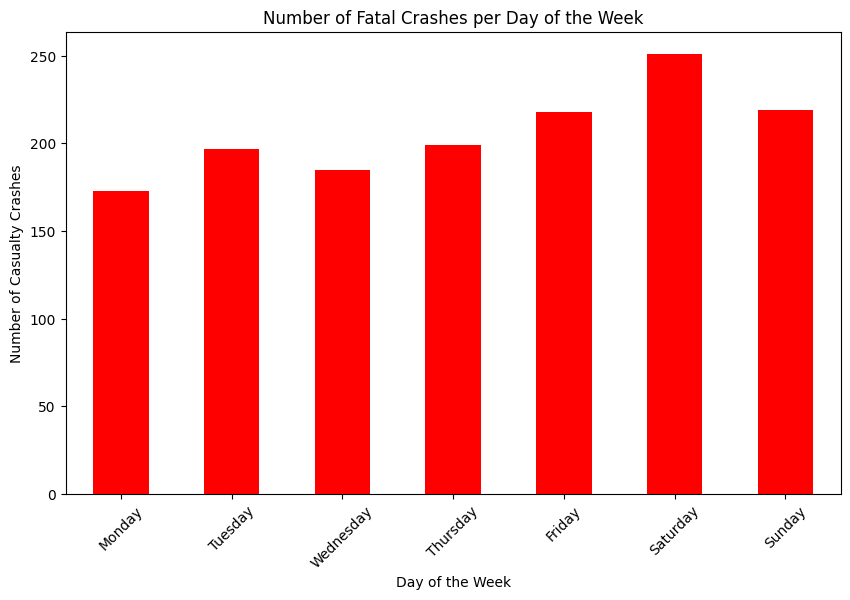

In [217]:
casualty_crashes = crash_data[crash_data['Degree of crash'] == 'Fatal']
casualty_counts_per_day_in_week = casualty_crashes['Day of week of crash'].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.figure(figsize=(10, 6))
casualty_counts_per_day_in_week.plot(kind='bar', color='red')
plt.title('Number of Fatal Crashes per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Casualty Crashes')
plt.xticks(rotation=45)
plt.show()

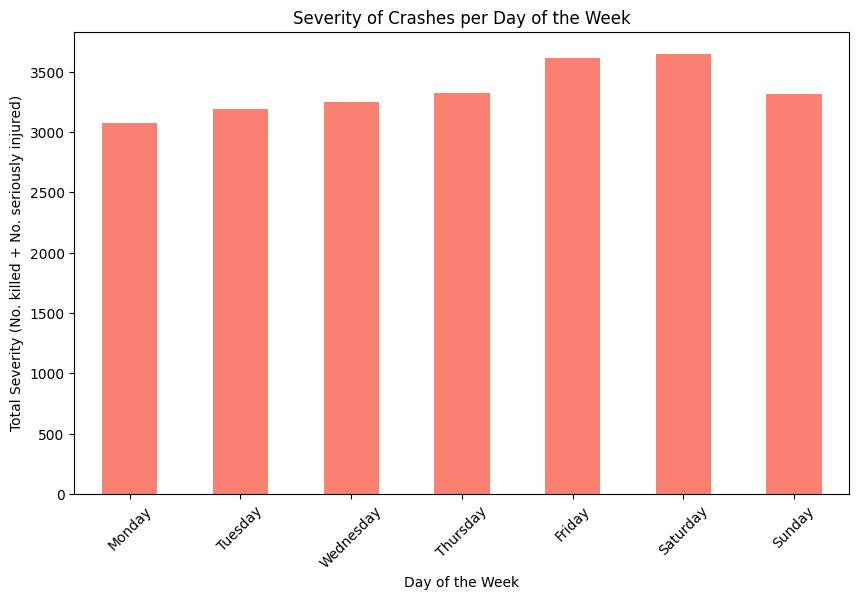

Done the graph of severity


In [218]:
crash_data['Severity'] = crash_data['No. killed'] + crash_data['No. seriously injured']
severity_per_day = crash_data.groupby('Day of week of crash')['Severity'].sum().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
plt.figure(figsize=(10, 6))
severity_per_day.plot(kind='bar', color='salmon')
plt.title('Severity of Crashes per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Severity (No. killed + No. seriously injured)')
plt.xticks(rotation=45)
plt.show()

print("Done the graph of severity")

We now make some analysis to the time frame of the crash on the days with less crash, and the days with more crash.

In [219]:
def categorize_time(interval):
    time_map = {
        "Midnight": ["22:00 - 23:59", "00:00 - 01:59", "02:00 - 03:59"],
        "Morning": ["04:00 - 05:59", "06:00 - 07:59", "08:00 - 09:59"],
        "Noon": ["10:00 - 11:59", "12:00 - 13:59"],
        "Evening": ["14:00 - 15:59", "16:00 - 17:59", "18:00 - 19:59", "20:00 - 21:59"]
    }
    
    for timeName in time_map:
        if interval in time_map[timeName]:
            return timeName
    return "Unknown"

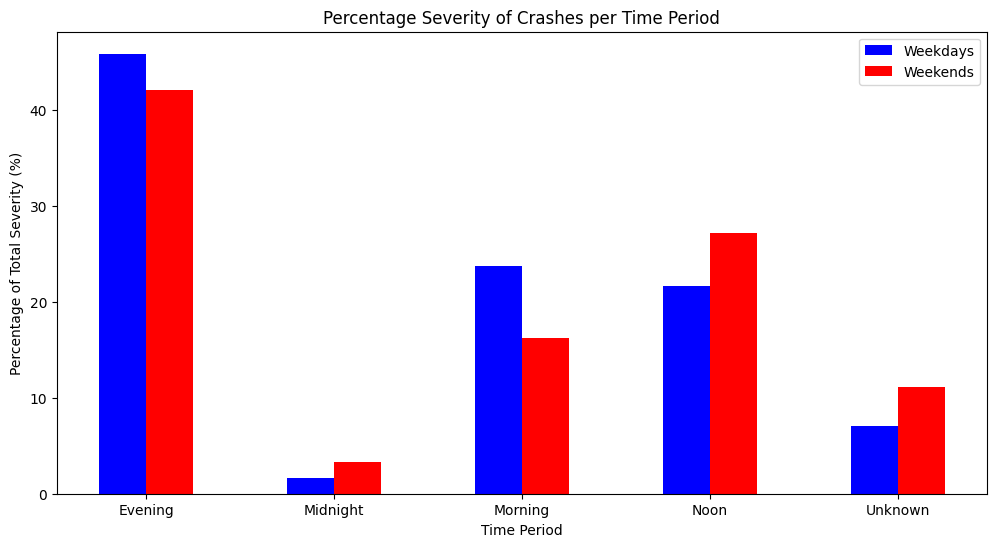

Done


In [220]:
crash_data['Time Period'] = crash_data['Two-hour intervals'].apply(categorize_time)

weekdays = crash_data[crash_data['Day of week of crash'].apply(lambda x: x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
weekends = crash_data[crash_data['Day of week of crash'].apply(lambda x: x in ['Saturday', 'Sunday'])]

severity_weekdays = weekdays.groupby('Time Period')['Severity'].sum()
severity_weekends = weekends.groupby('Time Period')['Severity'].sum()

total_weekdays = severity_weekdays.sum()
total_weekends = severity_weekends.sum()

combined_severity = pd.concat([severity_weekdays, severity_weekends], axis=1, keys=['Weekdays', 'Weekends'])

# Plotting grouped bar graph
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = range(len(combined_severity))

weekday_percentage = combined_severity['Weekdays'] / total_weekdays * 100.0
plt.bar(index, weekday_percentage, bar_width, color='blue', label='Weekdays')

# Plot weekends severity
weekend_percentage = combined_severity['Weekends'] / total_weekends * 100.0
plt.bar([i + bar_width for i in index], weekend_percentage, bar_width, color='red', label='Weekends')

plt.xlabel('Time Period')
plt.ylabel('Percentage of Total Severity (%)')
plt.title('Percentage Severity of Crashes per Time Period')
plt.xticks([i + bar_width / 2 for i in index], combined_severity.index)
plt.legend()
# plt.tight_layout()
plt.show()

print("Done")

We observe higher percentages of fatal crashes occurring during the morning and evening on weekdays, which aligns with typical commuting times. Conversely, more fatal crashes happened during the noon and midnight on weekends. These findings are quite logical. Weekdays see increased traffic during morning and evening rush hours due to work and school commutes, naturally increasing the likelihood of accidents during these times. Conversely, weekends witness higher rates of alcohol consumption and leisure activities throughout the whole day, leading to high transportation activity during the noon and late hours. During the noon, people are actively engaged in social activities, while in the midnight, they are either still out or heading home after social gatherings.

In [221]:
fatalities_by_car_type = casualty_crashes.groupby('Key TU type')['No. killed'].sum()

fatalities_by_car_type_sorted = fatalities_by_car_type.sort_values(ascending=False)

fatalities_by_car_type_sorted

Key TU type
Car (sedan/hatch)                 531
Motorcycle                        223
Light truck utility(from 2018)    212
4 wheel drive                     208
Station wagon                      61
Large rigid                        56
Light truck                        46
Pedal cycle                        35
B-double (road train prior 98)     33
Semi-trailer                       33
Utility                            28
Passenger van                      19
Other bus                          12
Unknown motor vehicle               9
STA bus                             8
Motor scooter                       7
Rigid tanker                        3
Motorised scooter (mob. aid)        3
Mot. wheelchair                     2
Quad bike                           2
Road train                          2
Self prop plant                     2
Motorised push scooters             1
Artic tanker                        1
Panel van                           1
MC & sidecar                        1


In [222]:
def categorize_crash(row):
    key_type = row['Key TU type']
    other_type = row['Other TU type']
    return f'{key_type} vs {other_type}'
crash_data['Crash Type'] = crash_data.apply(categorize_crash, axis=1)

fatal_crash_type_sorted = crash_data.groupby('Crash Type')['No. killed'].sum()

fatal_crash_type_sorted = fatal_crash_type_sorted.sort_values(ascending=False)

fatal_crash_type_sorted.head(20)

Crash Type
Car (sedan/hatch) vs nan                               233
Motorcycle vs nan                                      149
Light truck utility(from 2018) vs nan                  110
4 wheel drive vs nan                                    90
Car (sedan/hatch) vs Pedestrian                         78
Car (sedan/hatch) vs Car (sedan/hatch)                  61
Car (sedan/hatch) vs 4 wheel drive                      42
Light truck utility(from 2018) vs Pedestrian            35
4 wheel drive vs Pedestrian                             33
Car (sedan/hatch) vs Light truck utility(from 2018)     31
Car (sedan/hatch) vs Large rigid                        29
Station wagon vs nan                                    22
4 wheel drive vs Car (sedan/hatch)                      20
Light truck vs Pedestrian                               18
Large rigid vs Pedestrian                               17
Motorcycle vs 4 wheel drive                             17
Pedal cycle vs nan                           

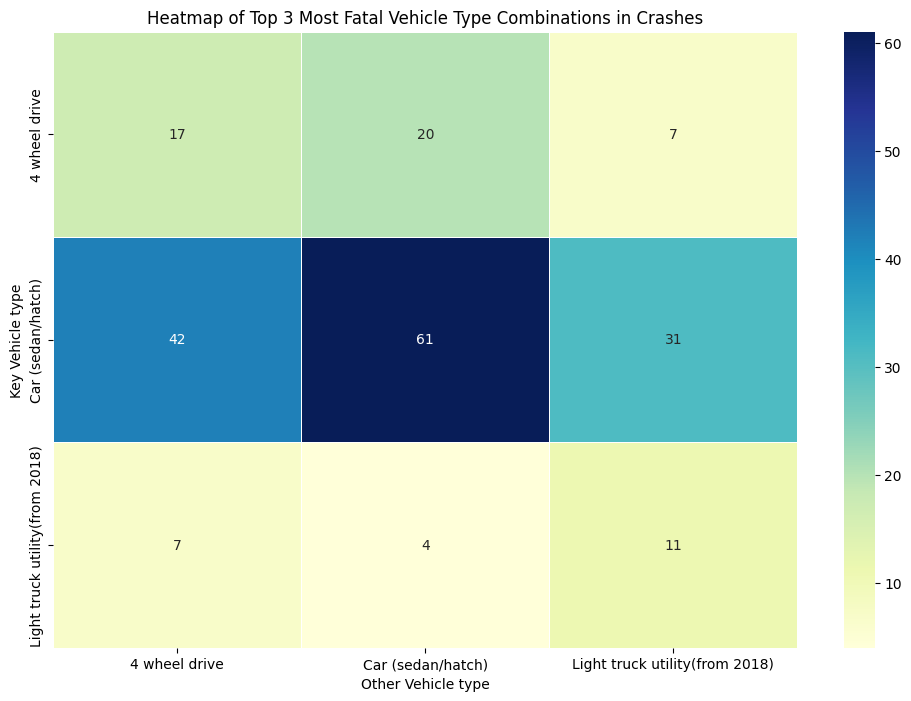

In [223]:
import seaborn as sns

top_3_key_tu_types = crash_data['Key TU type'].value_counts().head(3).index
top_3_other_tu_types = crash_data['Other TU type'].value_counts().head(3).index

#Filter the most 3 fatal crashes
top_3_fatal_crashes = crash_data[
    (crash_data['Key TU type'].isin(top_3_key_tu_types)) &
    (crash_data['Other TU type'].isin(top_3_other_tu_types))
]

#use tje pivot table to show the confusion data
confusion_matrix_data = top_3_fatal_crashes.pivot_table(
    index='Key TU type', 
    columns='Other TU type', 
    values='No. killed', 
    aggfunc='sum', 
    fill_value=0
)
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title('Heatmap of Top 3 Most Fatal Vehicle Type Combinations in Crashes')
plt.xlabel('Other Vehicle type')
plt.ylabel('Key Vehicle type')
plt.show()

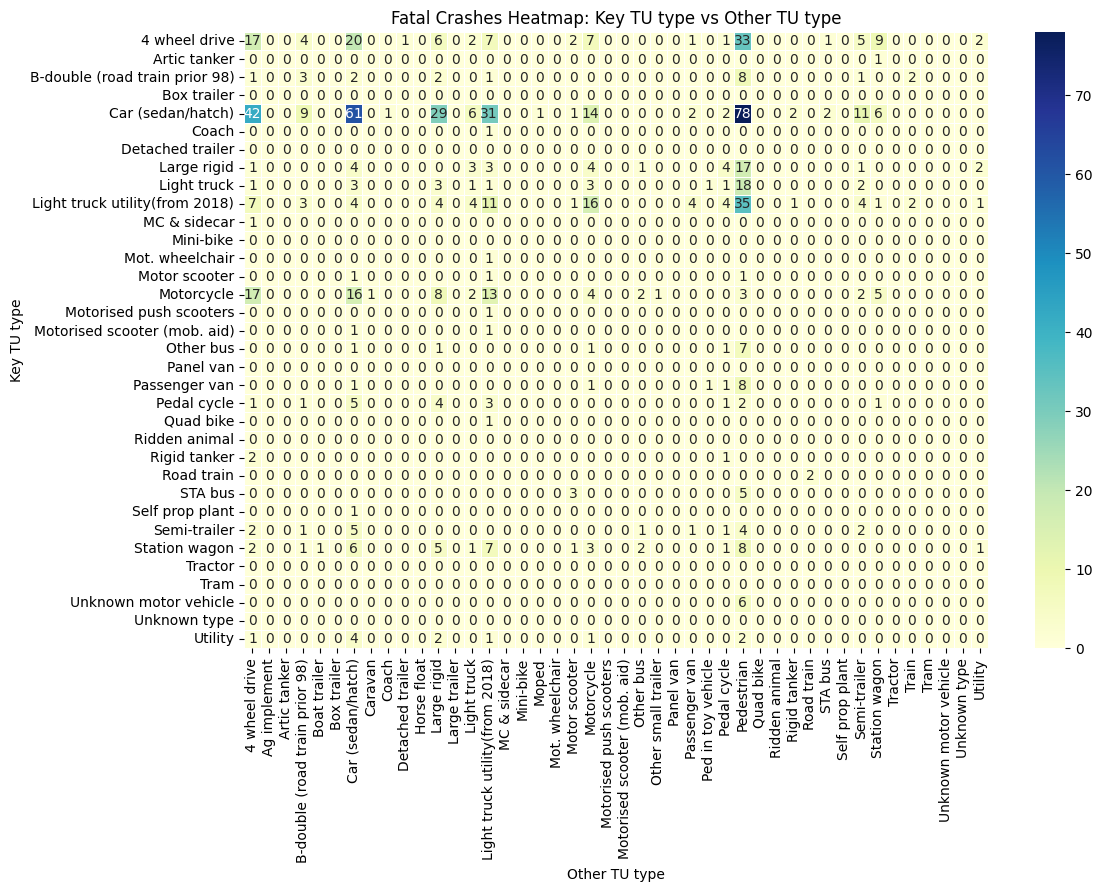

In [224]:
confusion_matrix_data = crash_data.pivot_table(index='Key TU type', columns='Other TU type', values='No. killed', aggfunc='sum', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title('Fatal Crashes Heatmap: Key TU type vs Other TU type')
plt.xlabel('Other TU type')
plt.ylabel('Key TU type')
plt.show()

using confusion map to show this data.

Show the color of different suburbs and the clashes： crashes per populations.

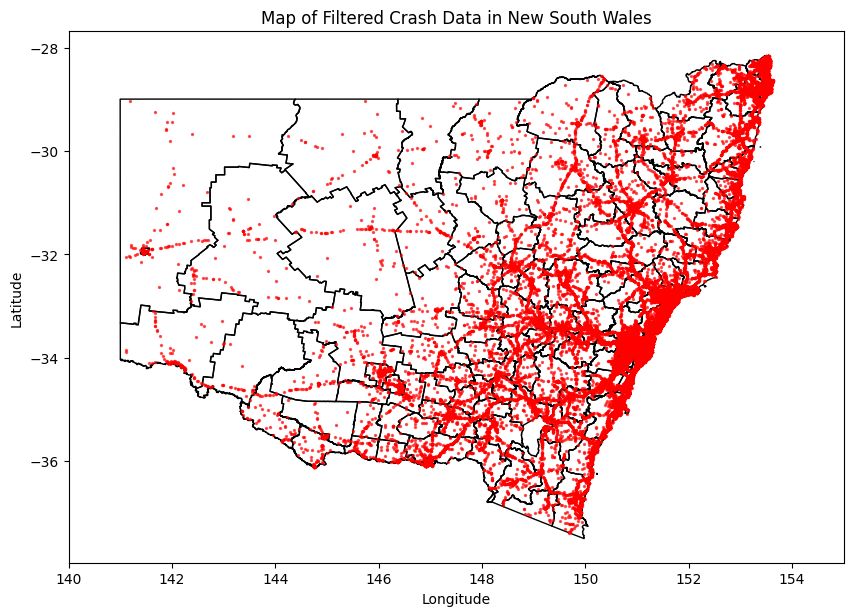

In [225]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import pandas as pd


# Define valid ranges for New South Wales (longitude and latitude)
nsw_longitude_range = (140, 154)  # Approximate range for NSW
nsw_latitude_range = (-38, -28)   # Approximate range for NSW

# Filter the data for crashes within the NSW range
filtered_data = crash_data[
    (crash_data['Longitude'] >= nsw_longitude_range[0]) &
    (crash_data['Longitude'] <= nsw_longitude_range[1]) &
    (crash_data['Latitude'] >= nsw_latitude_range[0]) &
    (crash_data['Latitude'] <= nsw_latitude_range[1])
]

filtered_points = gpd.GeoDataFrame(filtered_data, geometry=gpd.points_from_xy(filtered_data['Longitude'], filtered_data['Latitude']))

geojson_file = './australia.json'  # Adjust the filename if needed
gdf = gpd.read_file(geojson_file)

nsw_gdf = gdf[gdf['NAME_1'] == 'NewSouthWales']

# Plot the NSW boundary
fig, axs = plt.subplots(figsize=(10, 8))
nsw_gdf.boundary.plot(ax=axs, color='black', linewidth=1)

filtered_points.plot(ax=axs, marker='o', markersize=2, alpha=0.6, color='red', zorder=2) 

axs.set_xlim(left=nsw_longitude_range[0], right=155) 

axs.set_title('Map of Filtered Crash Data in New South Wales')
axs.set_xlabel('Longitude')
axs.set_ylabel('Latitude')

# Show the plot
plt.show()


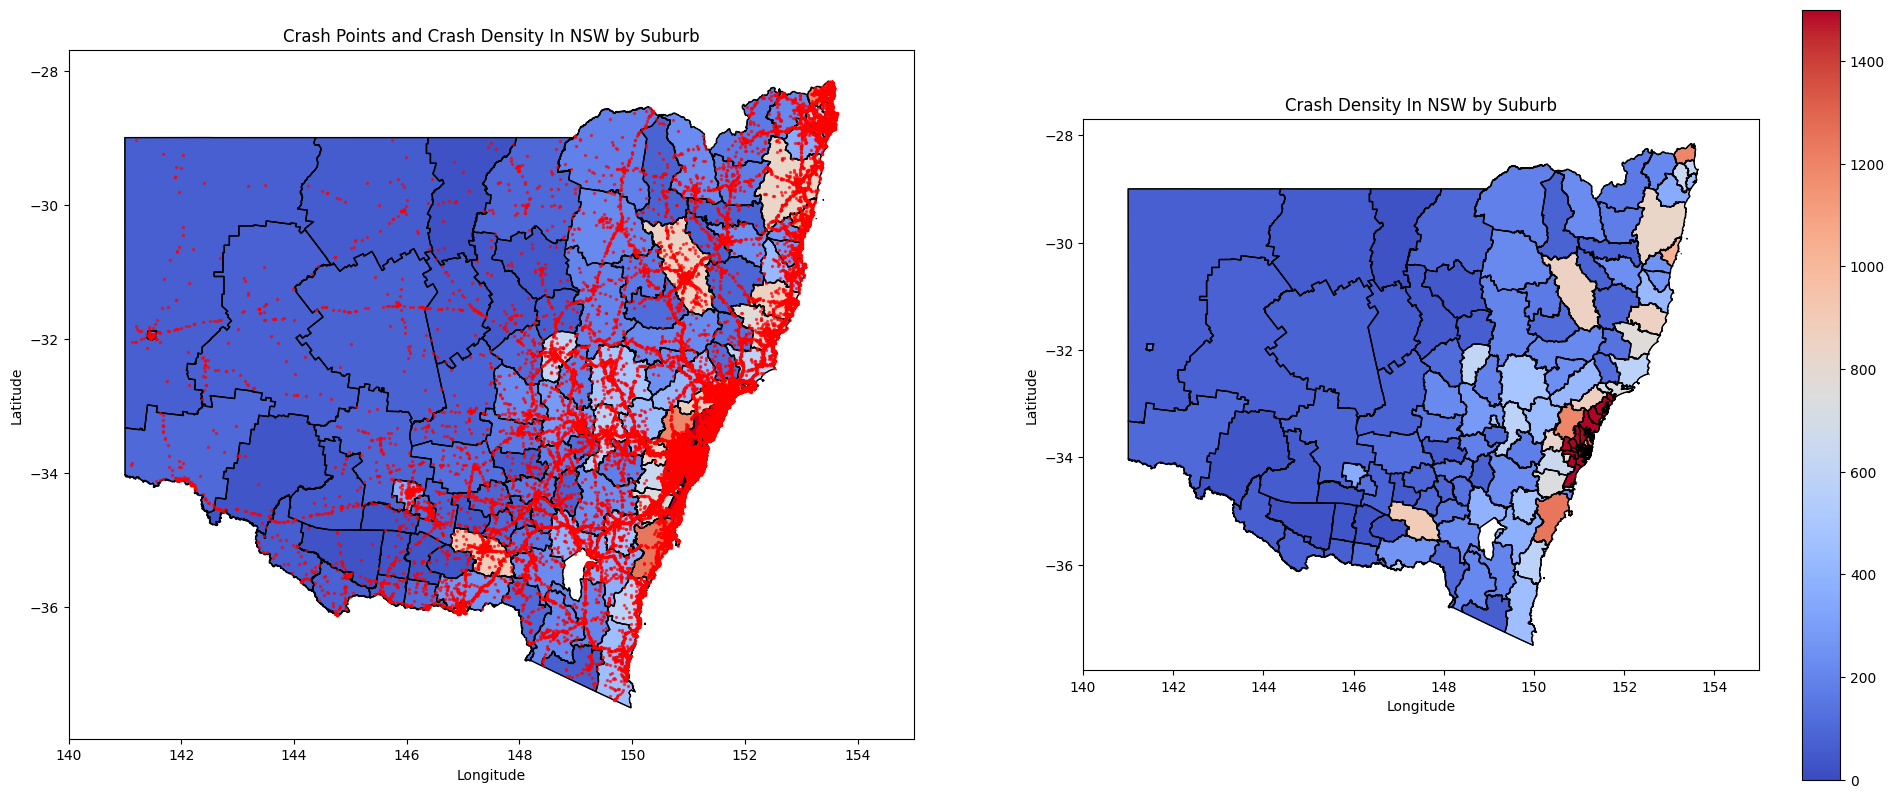

In [226]:
# Ensure CRS is set and consistent
if filtered_points.crs is None:
    filtered_points.crs = "EPSG:4326"  # Or set to the correct CRS if different
if filtered_points.crs != nsw_gdf.crs:
    filtered_points = filtered_points.to_crs(nsw_gdf.crs)

# Perform the spatial join
crashes_with_suburb = gpd.sjoin(filtered_points, nsw_gdf, how='left', predicate='within')

# Calculate the number of crashes per suburb
crashes_per_suburb = crashes_with_suburb.groupby('NAME_2').size().reset_index(name='crash_count')

# Merge the crash counts with the NSW GeoDataFrame
nsw_suburbs = nsw_gdf.merge(crashes_per_suburb, left_on='NAME_2', right_on='NAME_2', how='left')

# Fill any NaN values in the crash_count column with 0 (if a suburb has no crashes)
nsw_suburbs['crash_count'] = nsw_suburbs['crash_count'].fillna(0)

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

# Plot the map with color gradient based on crash counts
nsw_suburbs.boundary.plot(ax=axs[1], color='black', linewidth=1)
nsw_suburbs.plot(column='crash_count', ax=axs[1], cmap='coolwarm', 
                 legend=True, edgecolor='black', linewidth=0.5,
                 vmin=0, vmax=1500)
axs[1].set_title('Crash Density In NSW by Suburb')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].set_xlim(left=nsw_longitude_range[0], right=155)

# Plot the filtered crash points
nsw_suburbs.boundary.plot(ax=axs[0], color='black', linewidth=1)
nsw_suburbs.plot(column='crash_count', ax=axs[0], cmap='coolwarm', 
                 edgecolor='black', linewidth=0.5,
                 vmin=0, vmax=1500)
filtered_points.plot(ax=axs[0], marker='o', markersize=2, alpha=0.6, color='red', zorder=2)
axs[0].set_title('Crash Points and Crash Density In NSW by Suburb')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].set_xlim(left=nsw_longitude_range[0], right=155)

# Show the plot
plt.show()

In [227]:
import pandas as pd

# Suburb of interest
sydney_suburb = 'Sydney'

# Filter the GeoDataFrame to include only the suburb of interest
sydney_geometry = nsw_gdf[nsw_gdf['NAME_2'] == sydney_suburb].geometry.iloc[0]

# Find all suburbs adjacent to Sydney
adjacent_suburbs = nsw_gdf[nsw_gdf.geometry.intersects(sydney_geometry)]

# Filter the crash counts for these adjacent suburbs
adjacent_crashes = crashes_per_suburb[crashes_per_suburb['NAME_2'].isin(adjacent_suburbs['NAME_2'])]

# Add a rank column to crashes_per_suburb
crashes_per_suburb['rank'] = crashes_per_suburb['crash_count'].rank(ascending=False)

# Merge the rank information with the adjacent crashes DataFrame
adjacent_crashes_with_rank = adjacent_crashes.merge(crashes_per_suburb[['NAME_2', 'rank']], on='NAME_2')

# Print the adjacent districts with their crash counts and ranks
print("Adjacent districts to Sydney, their crash count, and rank:")
print(adjacent_crashes_with_rank[['NAME_2', 'crash_count', 'rank']].sort_values(by='rank'))



Adjacent districts to Sydney, their crash count, and rank:
         NAME_2  crash_count  rank
4        Sydney         3200   2.0
3      Randwick         1456  20.0
2  Marrickville         1234  25.0
0     BotanyBay          702  44.0
1    Leichhardt          544  58.0
5     Woollahra          501  59.0


Longitude range: 151.1286 to 151.2878
Latitude range: -34.0016 to -33.8325


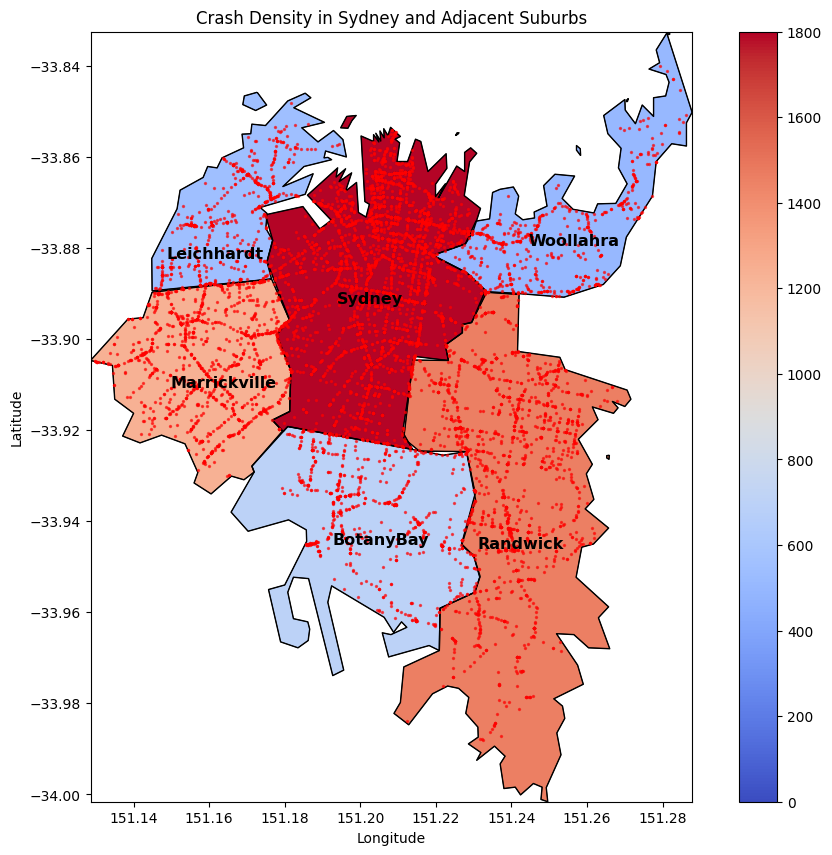

In [228]:
adjacency_district_to_sydney_data = nsw_suburbs[nsw_suburbs['NAME_2'].isin(adjacent_suburbs['NAME_2'])]

# Calculate the bounds (min and max longitude and latitude)
minx, miny, maxx, maxy = adjacency_district_to_sydney_data.total_bounds

# Print the ranges
print(f"Longitude range: {minx} to {maxx}")
print(f"Latitude range: {miny} to {maxy}")

# Create a single subplot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the map with color gradient based on crash counts for Sydney and adjacent suburbs
adjacency_district_to_sydney_data.boundary.plot(ax=ax, color='black', linewidth=1)
adjacency_district_to_sydney_data.plot(column='crash_count', ax=ax, cmap='coolwarm', 
                                        legend=True, edgecolor='black', linewidth=0.5,
                                        vmin=0, vmax=1800)
# Add annotations for district names
for idx, row in adjacency_district_to_sydney_data.iterrows():
    # Get the centroid of each district polygon for annotation
    centroid = row['geometry'].centroid
    # Define offset
    x_offset, y_offset = (-25, -9)
    # Check if the current district is 'Leichhardt'
    if row['NAME_2'] == 'Leichhardt':
        x_offset, y_offset = (-53, -40)
    elif row['NAME_2'] == 'Woollahra':
        x_offset, y_offset = (-35, -25)
    
    ax.annotate(text=row['NAME_2'], xy=(centroid.x, centroid.y), 
                xytext=(x_offset, y_offset),  # Use customized offsets
                textcoords='offset points', fontsize=11.5, color='black', weight='bold')
ax.set_title('Crash Density in Sydney and Adjacent Suburbs')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
points_within_boundary = filtered_points[filtered_points.geometry.apply(lambda geom: any(adjacency_district_to_sydney_data.contains(geom)))]
points_within_boundary.plot(ax=ax, marker='o', markersize=2, alpha=0.6, color='red', zorder=2)
ax.set_xlim(left=minx, right=maxx)
ax.set_ylim(bottom=miny, top=maxy)

# Show the plot
plt.show()

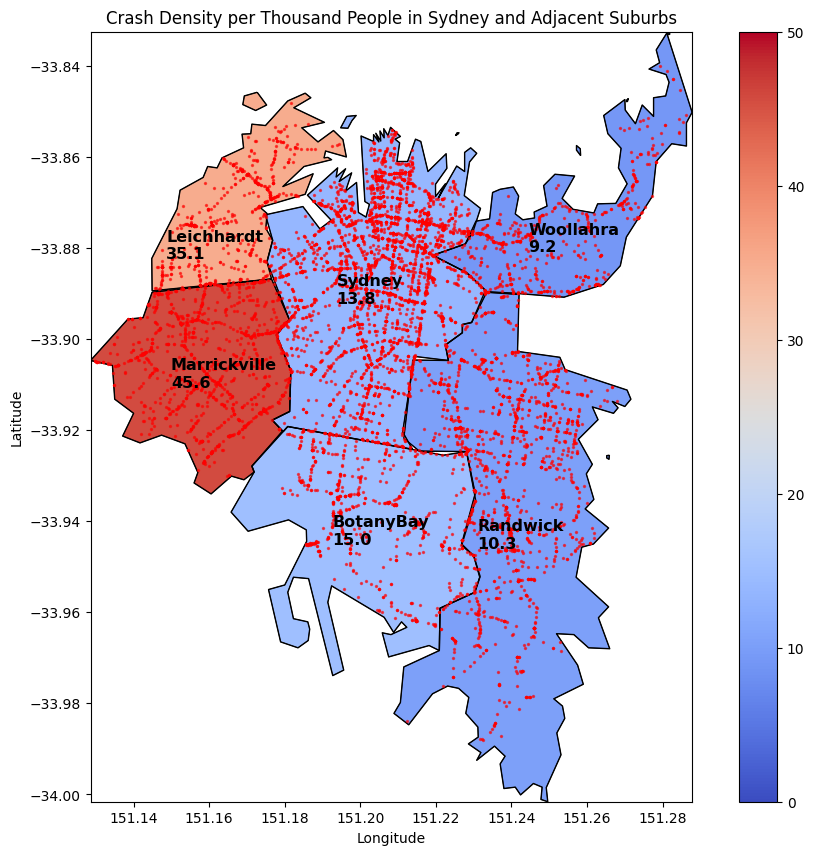

In [229]:
import matplotlib.pyplot as plt

# Define the population data
population_data = {
    "Sydney": 231.09,
    "Leichhardt": 15.48,
    "Randwick": 141.84,
    "Woollahra": 54.66,
    "Marrickville": 27.06,
    "BotanyBay": 46.65
}  # Unit: thousands of people

# Create a DataFrame from the population data
population_df = pd.DataFrame(list(population_data.items()), columns=['NAME_2', 'population'])

# Merge the population data with the GeoDataFrame
pop_adjacency_district_to_sydney_data = adjacency_district_to_sydney_data.merge(population_df, on='NAME_2')

# Calculate crash/population ratio per thousand people
pop_adjacency_district_to_sydney_data['crash_per_thousand'] = (pop_adjacency_district_to_sydney_data['crash_count'] / pop_adjacency_district_to_sydney_data['population'])

# Calculate the bounds (min and max longitude and latitude)
minx, miny, maxx, maxy = pop_adjacency_district_to_sydney_data.total_bounds

# Create a single subplot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the map with color gradient based on crash/population ratio
pop_adjacency_district_to_sydney_data.boundary.plot(ax=ax, color='black', linewidth=1)
pop_adjacency_district_to_sydney_data.plot(column='crash_per_thousand', ax=ax, cmap='coolwarm', 
                                        legend=True, edgecolor='black', linewidth=0.5,
                                        vmin=0, vmax=50)  # Adjust vmax based on your data range

# Add annotations for district names
for idx, row in pop_adjacency_district_to_sydney_data.iterrows():
    # Get the centroid of each district polygon for annotation
    centroid = row['geometry'].centroid
    # Define offset
    x_offset, y_offset = (-25, -9)
    # Check if the current district is 'Leichhardt'
    if row['NAME_2'] == 'Leichhardt':
        x_offset, y_offset = (-53, -40)
    elif row['NAME_2'] == 'Woollahra':
        x_offset, y_offset = (-35, -30)
    
    ax.annotate(text=row['NAME_2'] + f"\n{row['crash_per_thousand']:.1f}", xy=(centroid.x, centroid.y), 
                xytext=(x_offset, y_offset),  # Use customized offsets
                textcoords='offset points', fontsize=11.5, color='black', weight='bold')

# Add title and labels
ax.set_title('Crash Density per Thousand People in Sydney and Adjacent Suburbs')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot points within the boundary
points_within_boundary = filtered_points[filtered_points.geometry.apply(lambda geom: any(pop_adjacency_district_to_sydney_data.contains(geom)))]
points_within_boundary.plot(ax=ax, marker='o', markersize=2, alpha=0.6, color='red', zorder=2)

# Set limits based on the previous plot
ax.set_xlim(left=minx, right=maxx)
ax.set_ylim(bottom=miny, top=maxy)

# Show the plot
plt.show()


In [230]:

adjacent_crashes_dict = adjacent_crashes_with_rank[['NAME_2', 'crash_count', 'rank']].sort_values(by='rank').set_index('NAME_2').to_dict(orient='index')

# Print the dictionary
print(adjacent_crashes_dict)

{'Sydney': {'crash_count': 3200, 'rank': 2.0}, 'Randwick': {'crash_count': 1456, 'rank': 20.0}, 'Marrickville': {'crash_count': 1234, 'rank': 25.0}, 'BotanyBay': {'crash_count': 702, 'rank': 44.0}, 'Leichhardt': {'crash_count': 544, 'rank': 58.0}, 'Woollahra': {'crash_count': 501, 'rank': 59.0}}


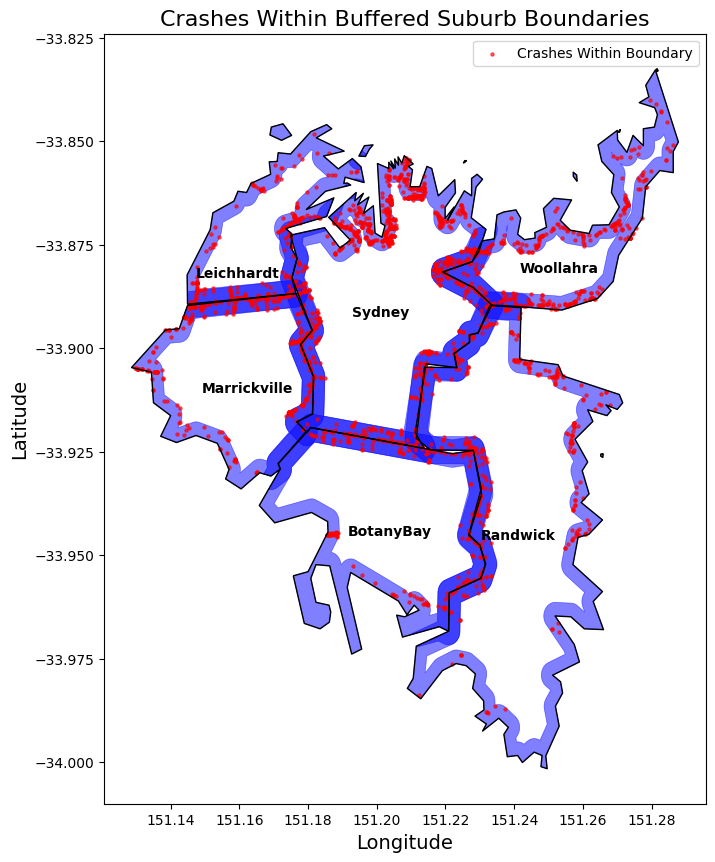

In [231]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Extract the boundaries of each suburb
boundary_districts = pop_adjacency_district_to_sydney_data.boundary

boundary_size = 0.0033  # around 400 meters

# Buffer the boundaries
buffered_boundaries = boundary_districts.buffer(
    distance=boundary_size,  # Buffer distance in degrees (approximately 400 meters)
    resolution=10,
    cap_style='round',
    join_style='round',
    mitre_limit=1.0,
    single_sided=False
)

# Create the inner boundary
inner_boundary = buffered_boundaries.intersection(pop_adjacency_district_to_sydney_data.unary_union)

# Filter crashes within the inner boundary
crashes_within_boundary = points_within_boundary[points_within_boundary.geometry.apply(
    lambda geom: any(inner_boundary.contains(geom))
)]

# Create a single subplot for visualization
fig, ax = plt.subplots(figsize=(12, 10))

pop_adjacency_district_to_sydney_data.boundary.plot(ax=ax, color='black', linewidth=1)

# Add annotations for district names
for idx, row in pop_adjacency_district_to_sydney_data.iterrows():
    # Get the centroid of each district polygon for annotation
    centroid = row['geometry'].centroid
    # Define offset
    x_offset, y_offset = (-25, -9)
    # Check if the current district is 'Leichhardt'
    if row['NAME_2'] == 'Leichhardt':
        x_offset, y_offset = (-51, -38)
    elif row['NAME_2'] == 'Woollahra':
        x_offset, y_offset = (-39, -30)
    
    ax.annotate(text=row['NAME_2'], xy=(centroid.x, centroid.y), 
                xytext=(x_offset, y_offset),  # Use customized offsets
                textcoords='offset points', fontsize=10, color='black', weight='bold')

inner_boundary.plot(ax=ax, color='blue', alpha=0.5, edgecolor='blue', linestyle='-', linewidth=0.5, label='Inner Region')

# Plot the crashes within the boundary
crashes_within_boundary.plot(ax=ax, marker='o', markersize=5, color='red', alpha=0.6, label='Crashes Within Boundary')

# Add a title and labels
ax.set_title('Crashes Within Buffered Suburb Boundaries', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Add a legend
ax.legend()

# Show the plot
plt.show()

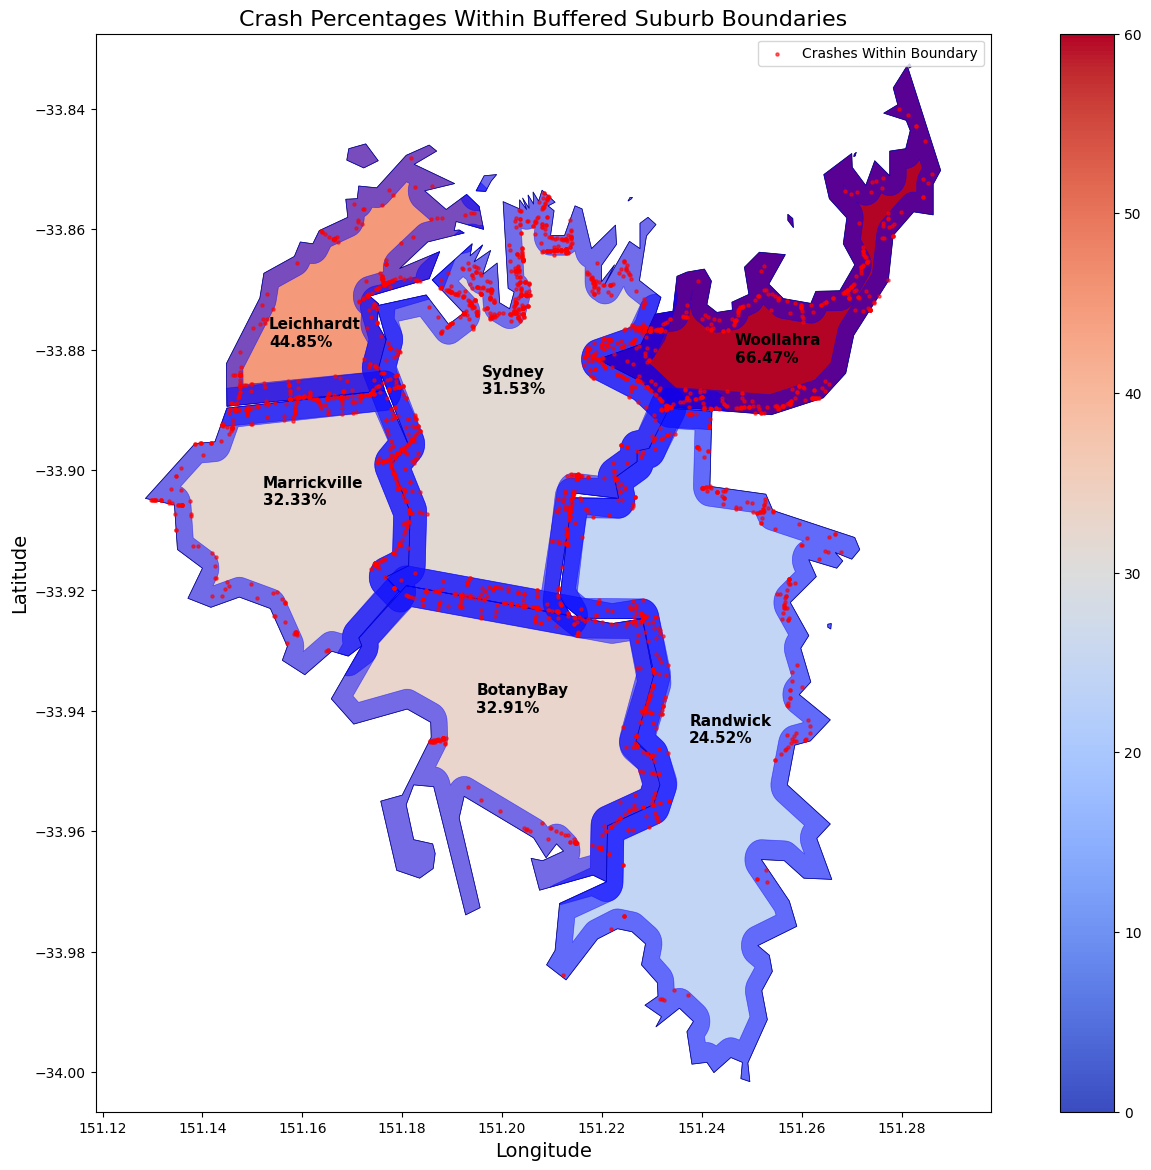

In [232]:
# Initialize results dictionary
results = {'NAME_2': [], 'crashes_within_boundary': [], 'total_crashes': [], 'percentage_within_boundary': []}

# Count crashes within the boundary for each district
for district in pop_adjacency_district_to_sydney_data['NAME_2']:
    # Get the boundary for the current district
    district_boundary = pop_adjacency_district_to_sydney_data[pop_adjacency_district_to_sydney_data['NAME_2'] == district]
    district_boundary = district_boundary.intersection(inner_boundary)
    crashes_in_district = points_within_boundary[points_within_boundary.geometry.apply(
        lambda geom: any(district_boundary.contains(geom))
    )]
    
    # Get total crashes for the district
    total_crashes = adjacent_crashes_dict[district]['crash_count']
    
    # Calculate the percentage
    percentage_within_boundary = (len(crashes_in_district) / total_crashes) * 100 if total_crashes > 0 else 0
    
    # Store results
    results['NAME_2'].append(district)
    results['crashes_within_boundary'].append(len(crashes_in_district))
    results['total_crashes'].append(total_crashes)
    results['percentage_within_boundary'].append(percentage_within_boundary)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Merge results with the original GeoDataFrame
pop_adjacency_district_to_sydney_data_boundary = pop_adjacency_district_to_sydney_data.merge(results_df, on='NAME_2')

# Create a single subplot for visualization
fig, ax = plt.subplots(figsize=(18, 14))

# Plot the map with color gradient based on crash percentage
pop_adjacency_district_to_sydney_data_boundary.plot(column='percentage_within_boundary', ax=ax, cmap='coolwarm',
                                            legend=True, edgecolor='black', linewidth=0.5,
                                            vmin=0, vmax=60)

# Plot the inner region
inner_boundary.plot(ax=ax, color='blue', alpha=0.5, edgecolor='blue', linestyle='-', linewidth=0.5, label='Inner Region')

# Plot crashes within the boundary
crashes_within_boundary.plot(ax=ax, marker='o', markersize=5, alpha=0.6, color='red', zorder=2, label='Crashes Within Boundary')

# Add annotations for each district with the percentage of crashes within the boundary
for district in results_df['NAME_2']:
    district_row = results_df[results_df['NAME_2'] == district].iloc[0]
    district_boundary = pop_adjacency_district_to_sydney_data_boundary[pop_adjacency_district_to_sydney_data_boundary['NAME_2'] == district]
    centroid = district_boundary.geometry.unary_union.centroid
    # Define offset
    x_offset, y_offset = (-25, 9)
    # Check if the current district is 'Leichhardt'
    if district == 'Leichhardt':
        x_offset, y_offset = (-53, -40)
    elif district == 'Woollahra':
        x_offset, y_offset = (-39, -45)
    elif district == 'Leichhardt':
        x_offset, y_offset = (-30, -15)
    elif district == 'Randwick':
        x_offset, y_offset = (-10, -9)
    
    ax.annotate(text=f"{district}\n{district_row['percentage_within_boundary']:.2f}%", xy=(centroid.x, centroid.y), 
                xytext=(x_offset, y_offset),  # Use customized offsets
                textcoords='offset points', fontsize=11, color='black', weight='bold')

# Set the plot title and labels
ax.set_title('Crash Percentages Within Buffered Suburb Boundaries', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Set axis limits to zoom in on the area of interest
# Adjust these limits based on your specific area of interest
xmin, ymin, xmax, ymax = pop_adjacency_district_to_sydney_data_boundary.total_bounds
x_padding = 0.01  # Adjust padding if needed
y_padding = 0.005  # Adjust padding if needed
ax.set_xlim(xmin - x_padding, xmax + x_padding)
ax.set_ylim(ymin - y_padding, ymax + y_padding)

# Add a legend
ax.legend()

# Show the plot
plt.show()